Import useful/required packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from imports_Mirnov import *
from functions_Mirnov import *

Read coil positions from file

In [2]:
coilpos = np.asarray(xr.open_dataarray('Data/coil_positions.nc'))
coil_angles = np.arctan(coilpos[:,1]/(coilpos[:,0]-1.6)) # Convert coordinates to angles
#coil_nums = [204, 206, 207, 210, 212, 213, 214, 215, 216, 217, 218]

Read Mirnov data from file

In [3]:
mirnov_data_from_file = xr.open_dataarray('Data/shot29378_mirnov_data.nc')
mirnov_time = np.asarray(mirnov_data_from_file.coords['time']) # Shape: (650000,)
coil_nums = np.asarray(mirnov_data_from_file.coords['coil'])
mirnov_data = np.asarray(mirnov_data_from_file) # Shape: (11,650000)

Read equilibria data from file

In [4]:
equilib_from_file = xr.open_dataarray('Data/shot29378_equilibria.nc')
equilib_time = np.asarray(equilib_from_file.coords['time'])
equilib_R = np.asarray(equilib_from_file.coords['R'])
equilib_Z = np.asarray(equilib_from_file.coords['Z'])
equilib_psi = np.asarray(equilib_from_file) # Contains 135 length-65 arrays [0:134][0:64]

Define interesting timeslices

In [5]:
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.65]]

Make some plots of coil locations

In [6]:
# Plot coil positions alone
plot_coil_positions(coilpos, coil_angles, coil_nums, save=True)
# Plot coil positions with flux surfaces
#plot_coils_with_equilib(29378, coilpos, equilib_time[50], equilib_R, equilib_Z, equilib_psi[50])

Make some plots of the raw data

In [7]:
#for coil in range(len(coil_nums)):
#    plot_coil_data(29378, mirnov_time, mirnov_data, coil, timeslice=regions[2])
#    plot_coil_fft(29378, mirnov_time, mirnov_data, coil, timeslice=regions[2])

In [8]:
def plot_mirnov_spectrogram(
        shot, mirnov_time, mirnov_data, coil_indices, n, fname, timeslice=None,
        threshold=None, freq_lims=[0.0, 200.0], save=True):
    # plot the BES fluctuation data spectrogram for one or more channels
    
    if timeslice == None:
        timeslice = [mirnov_time[0], mirnov_time[-1]]
    idx1 = (np.abs(mirnov_time - timeslice[0])).argmin()
    idx2 = (np.abs(mirnov_time - timeslice[1])).argmin()
    
    freq, times, Sxx = sig.spectrogram(mirnov_data[:,idx1:idx2], fs=mirnov_f_samp, 
                                       nperseg=(2 ** n), scaling='spectrum')
    
    num_channels = len(coil_indices)
    levs = [10**i for i in range(-11,1)]
    new_lim = len(freq)#int(14 * (2 ** (n - 7)))

    figure, axes = plt.subplots(num_channels, 1, sharex=True, 
                                figsize=(10, 3 * num_channels))
    axes[0].set_title(str(shot) + ' BES spectrograms [kHz], n=' + 
        str(int(2 ** n)), fontsize=32)
    for i in range(num_channels):
        ch = coil_indices[i]
        ct = axes[i].contourf(times + mirnov_time[idx1], 0.001 * freq[:new_lim], 
            Sxx[ch][:new_lim,:], 16, cmap=plt.get_cmap('plasma'), levels=levs,
            norm=(colors.LogNorm()))
        axes[i].set_ylim(freq_lims)
        axes[i].tick_params(axis='y', labelsize=22)
        axes[i].set_ylabel(('Coil ' + str(coil_nums[ch])), fontsize=24)
        cbar = figure.colorbar(ct, shrink=0.9, label="Strength [a.u.]")
        if threshold is not None:
            axes[i].axvline(threshold, color='r')
    axes[num_channels-1].tick_params(axis='x', labelsize=24)
    axes[num_channels-1].set_xlabel('time [s]', fontsize=26)
    axes[num_channels-1].set_xlim(timeslice)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    if save == True:
        plt.savefig('shot' + str(shot) + '_mirnov_stfft_'+ fname +'.png', format='png', transparent=False)
    else:
        plt.show()
    plt.close()

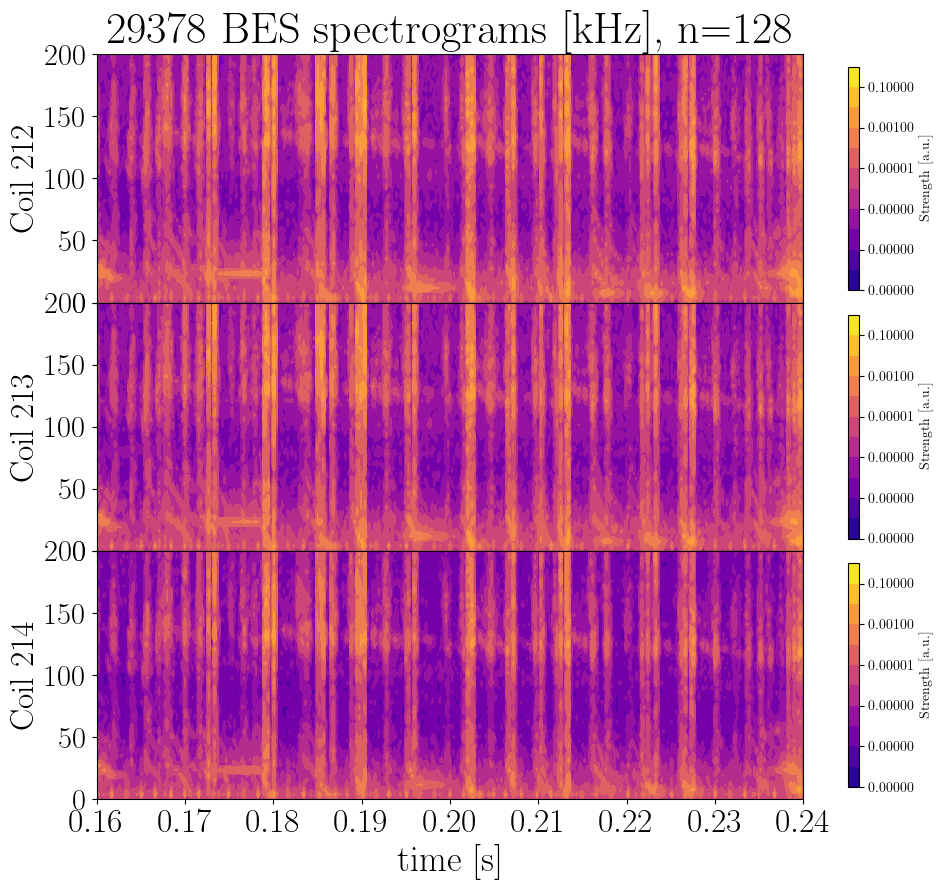

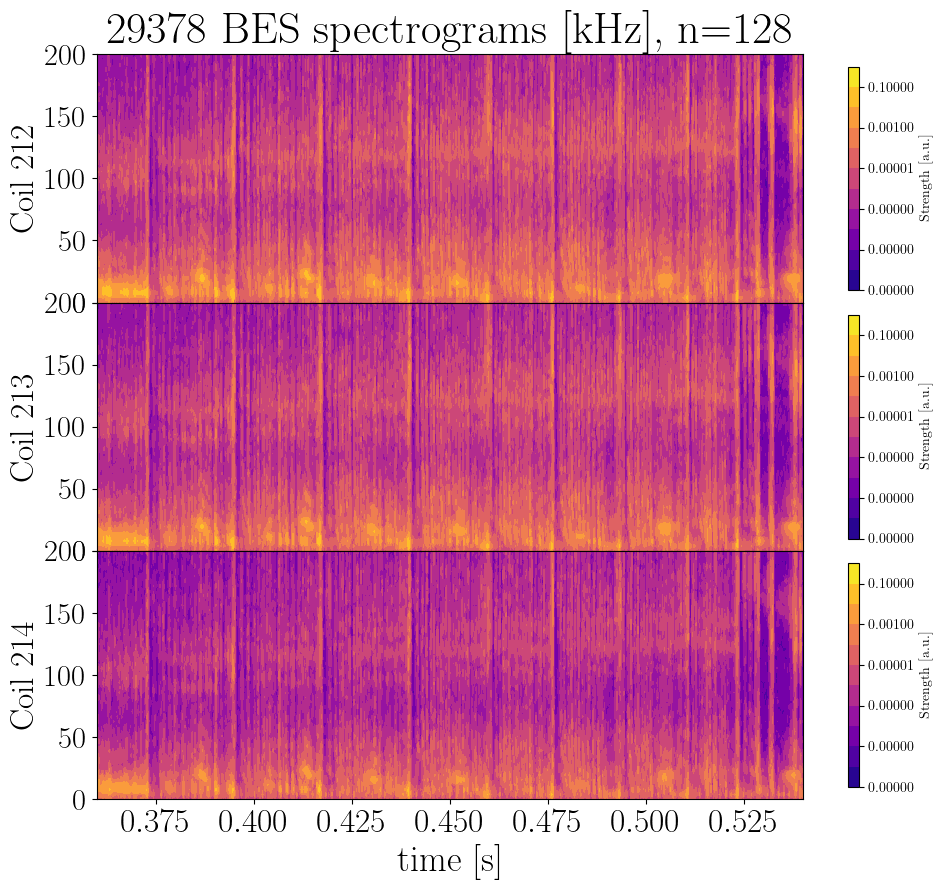

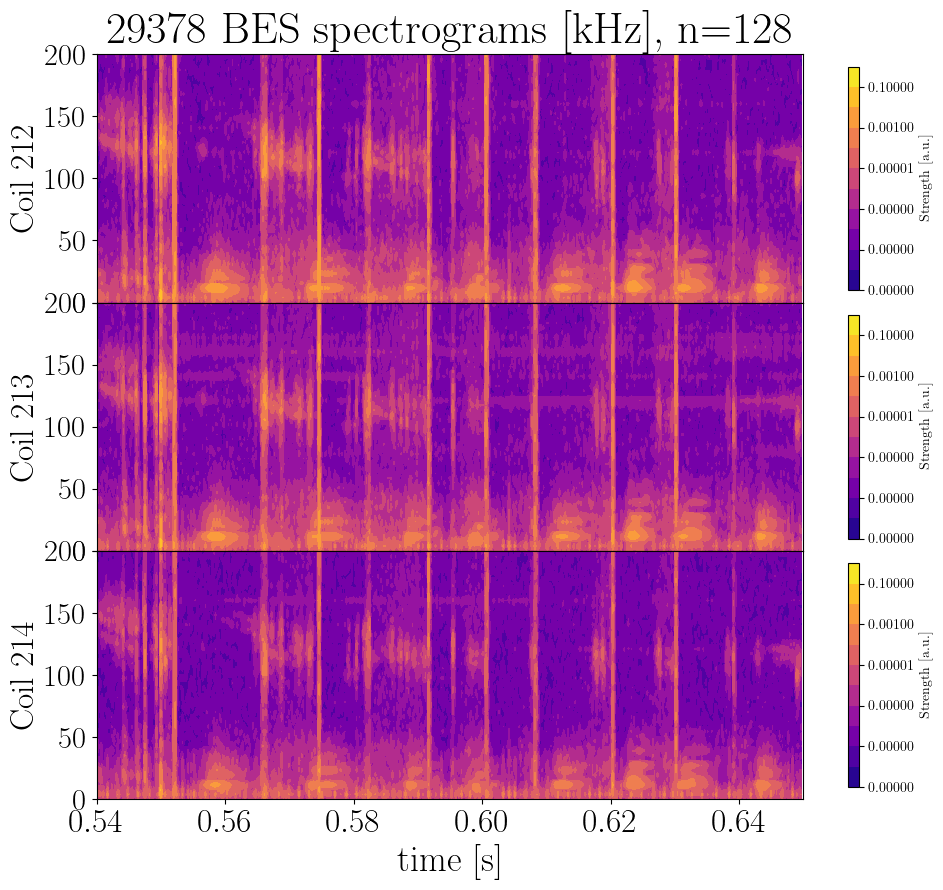

In [9]:
for region in range(3):
    plot_mirnov_spectrogram(29378, mirnov_time, mirnov_data, [i for i in range(4,7)], 7, "reg_" + str(region+1), timeslice=regions[region], save=False)